In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.notebook_repr_html', False)

act = pd.read_csv('OTg6QzA_activities.csv')
act.shape # 66281, 4

(66281, 4)

시계열 데이터 다루기
- 활동량 평가, 시각화화
- 리샘플링 집계, 결측치 제거
- 시계열 차트: 노약자의 활동지수와 패턴

In [2]:
act.head()

                 timestamp   X   Y   Z
0  2022-01-01 00:01:40.363  33  76  56
1  2022-01-01 00:01:42.961  34  87  56
2  2022-01-01 00:01:45.562  25  89  47
3  2022-01-01 00:01:48.163  11  70  50
4  2022-01-01 00:02:08.864  33  72  58

In [3]:
# 거리 및 속도 산출을 위해, 직전 데이터(t-1)를 새로운 열에 추가함
# shift(1)로 timestamp열값이 하나씩 아래로 이동된다.
act['p_timestamp'] = act['timestamp'].shift(1)
act['p_x'] = act['X'].shift(1)
act['p_y'] = act['Y'].shift(1)
act['p_z'] = act['Z'].shift(1)
act.head(5)

                 timestamp   X   Y   Z              p_timestamp   p_x   p_y  \
0  2022-01-01 00:01:40.363  33  76  56                     None   NaN   NaN   
1  2022-01-01 00:01:42.961  34  87  56  2022-01-01 00:01:40.363  33.0  76.0   
2  2022-01-01 00:01:45.562  25  89  47  2022-01-01 00:01:42.961  34.0  87.0   
3  2022-01-01 00:01:48.163  11  70  50  2022-01-01 00:01:45.562  25.0  89.0   
4  2022-01-01 00:02:08.864  33  72  58  2022-01-01 00:01:48.163  11.0  70.0   

    p_z  
0   NaN  
1  56.0  
2  56.0  
3  47.0  
4  50.0  

In [11]:
# NaN 값이 있는 행을 삭제하자. NaN가 있으면 거리 및 속도 계산할 수 없다.
# 첫 번째 행이 삭제될 것이다.
cleaned = act.dropna()
cleaned.head(5)

                 timestamp   X   Y   Z              p_timestamp   p_x   p_y  \
1  2022-01-01 00:01:42.961  34  87  56  2022-01-01 00:01:40.363  33.0  76.0   
2  2022-01-01 00:01:45.562  25  89  47  2022-01-01 00:01:42.961  34.0  87.0   
3  2022-01-01 00:01:48.163  11  70  50  2022-01-01 00:01:45.562  25.0  89.0   
4  2022-01-01 00:02:08.864  33  72  58  2022-01-01 00:01:48.163  11.0  70.0   
5  2022-01-01 00:02:21.765  21  68  58  2022-01-01 00:02:08.864  33.0  72.0   

    p_z  
1  56.0  
2  56.0  
3  47.0  
4  50.0  
5  58.0  

In [ ]:
# 직전 좌표값으로 두 지점 간의 거리를 산출한 값을 dist 열에 추가한다.

# 두 좌표값으로 거리를 계산하는 파이썬 함수
def calc_dist(df):
  x_d = df['X'] - df['p_x']
  y_d = df['Y'] - df['p_y']
  z_d = df['Z'] - df['p_z']
  return np.sqrt(x_d**2 + y_d**2 + z_d**2) #두 좌표값의 유클리드 거리 계산(각 차이의 제곱을 합산한 후 제곱근을 구하여 거리를 계산)

cleaned.loc[:,'dist'] = cleaned.loc[:, ['X','p_x', 'Y', 'p_y', 'Z', 'p_z']].apply(calc_dist, axis=1)
cleaned.head(5)

C:\Users\302-26\AppData\Local\Temp\ipykernel_4976\550447858.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned.loc[:,'dist'] = cleaned.loc[:, ['X','p_x', 'Y', 'p_y', 'Z', 'p_z']].apply(calc_dist, axis=1)


                 timestamp   X   Y   Z              p_timestamp   p_x   p_y  \
1  2022-01-01 00:01:42.961  34  87  56  2022-01-01 00:01:40.363  33.0  76.0   
2  2022-01-01 00:01:45.562  25  89  47  2022-01-01 00:01:42.961  34.0  87.0   
3  2022-01-01 00:01:48.163  11  70  50  2022-01-01 00:01:45.562  25.0  89.0   
4  2022-01-01 00:02:08.864  33  72  58  2022-01-01 00:01:48.163  11.0  70.0   
5  2022-01-01 00:02:21.765  21  68  58  2022-01-01 00:02:08.864  33.0  72.0   

    p_z       dist  
1  56.0  11.045361  
2  56.0  12.884099  
3  47.0  23.790755  
4  50.0  23.494680  
5  58.0  12.649111  

In [13]:
# 시간 차분을 구한 다음, d_time 열에 저장한다.
from datetime import datetime

# 시간 차분을 구하는 파이썬 함수
def calc_timediff(df):
  d1 = datetime.strptime(df['timestamp'], "%Y-%m-%d %H:%M:%S.%f")
  d2 = datetime.strptime(df['p_timestamp'], "%Y-%m-%d %H:%M:%S.%f")
  return (d1 - d2).total_seconds()

cleaned['d_time'] = cleaned[["timestamp","p_timestamp"]].apply(calc_timediff, axis=1)
cleaned.head(5)

C:\Users\302-26\AppData\Local\Temp\ipykernel_4976\368087065.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['d_time'] = cleaned[["timestamp","p_timestamp"]].apply(calc_timediff, axis=1)


                 timestamp   X   Y   Z              p_timestamp   p_x   p_y  \
1  2022-01-01 00:01:42.961  34  87  56  2022-01-01 00:01:40.363  33.0  76.0   
2  2022-01-01 00:01:45.562  25  89  47  2022-01-01 00:01:42.961  34.0  87.0   
3  2022-01-01 00:01:48.163  11  70  50  2022-01-01 00:01:45.562  25.0  89.0   
4  2022-01-01 00:02:08.864  33  72  58  2022-01-01 00:01:48.163  11.0  70.0   
5  2022-01-01 00:02:21.765  21  68  58  2022-01-01 00:02:08.864  33.0  72.0   

    p_z       dist  d_time  
1  56.0  11.045361   2.598  
2  56.0  12.884099   2.601  
3  47.0  23.790755   2.601  
4  50.0  23.494680  20.701  
5  58.0  12.649111  12.901  

In [14]:
cleaned

                     timestamp   X    Y    Z              p_timestamp   p_x  \
1      2022-01-01 00:01:42.961  34   87   56  2022-01-01 00:01:40.363  33.0   
2      2022-01-01 00:01:45.562  25   89   47  2022-01-01 00:01:42.961  34.0   
3      2022-01-01 00:01:48.163  11   70   50  2022-01-01 00:01:45.562  25.0   
4      2022-01-01 00:02:08.864  33   72   58  2022-01-01 00:01:48.163  11.0   
5      2022-01-01 00:02:21.765  21   68   58  2022-01-01 00:02:08.864  33.0   
...                        ...  ..  ...  ...                      ...   ...   
66276  2022-01-31 23:28:00.481 -91  143  136  2022-01-31 23:27:55.381 -92.0   
66277  2022-01-31 23:28:41.683 -89  145  138  2022-01-31 23:28:00.481 -91.0   
66278  2022-01-31 23:28:49.383 -93  138  137  2022-01-31 23:28:41.683 -89.0   
66279  2022-01-31 23:32:36.426 -93  131  137  2022-01-31 23:28:49.383 -93.0   
66280  2022-01-31 23:32:44.126 -91  129  138  2022-01-31 23:32:36.426 -93.0   

         p_y    p_z       dist   d_time  
1       7

In [16]:
"""
cleaned[["timestamp", "p_timestamp"]]는 cleaned.loc[:, ["timestamp", "p_timestamp"]]와 동일한 의미이다.
cleaned.loc[:, ["timestamp", "p_timestamp"]]는 cleaned DataFrame에서 timestamp열과 p_timestamp열의 모든 행을 뜻한다.
"""

print(cleaned.loc[:, ["timestamp", "p_timestamp"]])
print(cleaned[["timestamp", "p_timestamp"]])
# 데이터가 제대로 조작되고 있는지 이렇게 출력해 나가면 코드를 다루면 된다.

                     timestamp              p_timestamp
1      2022-01-01 00:01:42.961  2022-01-01 00:01:40.363
2      2022-01-01 00:01:45.562  2022-01-01 00:01:42.961
3      2022-01-01 00:01:48.163  2022-01-01 00:01:45.562
4      2022-01-01 00:02:08.864  2022-01-01 00:01:48.163
5      2022-01-01 00:02:21.765  2022-01-01 00:02:08.864
...                        ...                      ...
66276  2022-01-31 23:28:00.481  2022-01-31 23:27:55.381
66277  2022-01-31 23:28:41.683  2022-01-31 23:28:00.481
66278  2022-01-31 23:28:49.383  2022-01-31 23:28:41.683
66279  2022-01-31 23:32:36.426  2022-01-31 23:28:49.383
66280  2022-01-31 23:32:44.126  2022-01-31 23:32:36.426

[66280 rows x 2 columns]
                     timestamp              p_timestamp
1      2022-01-01 00:01:42.961  2022-01-01 00:01:40.363
2      2022-01-01 00:01:45.562  2022-01-01 00:01:42.961
3      2022-01-01 00:01:48.163  2022-01-01 00:01:45.562
4      2022-01-01 00:02:08.864  2022-01-01 00:01:48.163
5      2022-01-01 00:0

In [ ]:
"""
속도를 구한 다음, activity(활동평가지수) 열에 저장한다.
"""

# 거리/시간차분으로 속도를 구하는 파이썬 함수
def calc_act(df):
  if df['d_time'] != 0:
    return np.abs(df['dist'] / df['d_time'])
  else:
    # 정상적인 수가 아님.
    return 0

cleaned['calc_act'] = cleaned[["dist", "d_time"]].apply(calc_act, axis=1)
cleaned.head(5)

C:\Users\302-26\AppData\Local\Temp\ipykernel_4976\1181562818.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['calc_act'] = cleaned[["dist", "d_time"]].apply(calc_act, axis=1)


                 timestamp   X   Y   Z              p_timestamp   p_x   p_y  \
1  2022-01-01 00:01:42.961  34  87  56  2022-01-01 00:01:40.363  33.0  76.0   
2  2022-01-01 00:01:45.562  25  89  47  2022-01-01 00:01:42.961  34.0  87.0   
3  2022-01-01 00:01:48.163  11  70  50  2022-01-01 00:01:45.562  25.0  89.0   
4  2022-01-01 00:02:08.864  33  72  58  2022-01-01 00:01:48.163  11.0  70.0   
5  2022-01-01 00:02:21.765  21  68  58  2022-01-01 00:02:08.864  33.0  72.0   

    p_z       dist  d_time  calc_act  
1  56.0  11.045361   2.598  4.251486  
2  56.0  12.884099   2.601  4.953517  
3  47.0  23.790755   2.601  9.146772  
4  50.0  23.494680  20.701  1.134954  
5  58.0  12.649111  12.901  0.980475  

#속도 분포 확인

<Axes: title={'center': 'calculation of activity'}, xlabel='time series', ylabel='activity [cm/sec]'>

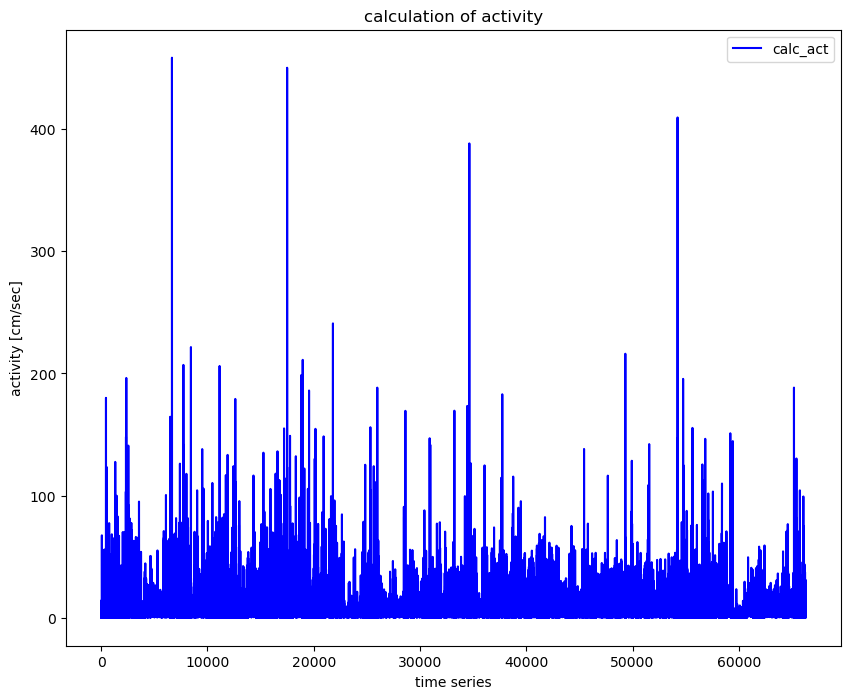

In [19]:
plt.rcParams['figure.figsize'] = [10, 8]
cleaned.plot(y="calc_act", color="b", title="calculation of activity", ylabel="activity [cm/sec]", xlabel="time series")

In [20]:
# 전체에서 움직임이 50[cm/sec] 이하의 비율을 구해보자
len(cleaned[cleaned['calc_act'] < 50.0])/len(cleaned)

0.9916113458056729

In [21]:
cleaned.dtypes

timestamp       object
X                int64
Y                int64
Z                int64
p_timestamp     object
p_x            float64
p_y            float64
p_z            float64
dist           float64
d_time         float64
calc_act       float64
dtype: object

In [85]:
act = cleaned.copy() #데이터프레임 복사
act = act[['timestamp', 'calc_act']]

#timestamp(문자열)를 datetime 데이터타입으로 변경
act['timestamp'] = act['timestamp'].astype('datetime64[ns]')
act.dtypes

timestamp    datetime64[ns]
calc_act            float64
dtype: object

In [86]:
#timestamp를 인덱스로
act = act.set_index('timestamp')
act

                         calc_act
timestamp                        
2022-01-01 00:01:42.961  4.251486
2022-01-01 00:01:45.562  4.953517
2022-01-01 00:01:48.163  9.146772
2022-01-01 00:02:08.864  1.134954
2022-01-01 00:02:21.765  0.980475
...                           ...
2022-01-31 23:28:00.481  3.167744
2022-01-31 23:28:41.683  0.084076
2022-01-31 23:28:49.383  1.055070
2022-01-31 23:32:36.426  0.030831
2022-01-31 23:32:44.126  0.389610

[66280 rows x 1 columns]

#10분 단위로 그룹화

In [87]:
tenmin = act.resample('10min')  #10분 단위로 리샘플링, tenmin(변수)
result1 = tenmin['calc_act'].agg(['mean', 'min', 'max'])  #egg(): 집계연산
print(result1) #(4462, 3)
result1 = result1.dropna()
print(result1) #(2363,3)

                          mean       min        max
timestamp                                          
2022-01-01 00:00:00   2.359774  0.205775   9.146772
2022-01-01 00:10:00   3.804910  0.011198  12.985407
2022-01-01 00:20:00   1.204413  0.176624   3.200697
2022-01-01 00:30:00   0.065608  0.065608   0.065608
2022-01-01 00:40:00        NaN       NaN        NaN
...                        ...       ...        ...
2022-01-31 22:50:00   5.271830  0.174116  16.061886
2022-01-31 23:00:00        NaN       NaN        NaN
2022-01-31 23:10:00  11.671627  0.090195  31.025631
2022-01-31 23:20:00   3.598816  0.032785  23.493043
2022-01-31 23:30:00   0.210221  0.030831   0.389610

[4462 rows x 3 columns]
                          mean       min        max
timestamp                                          
2022-01-01 00:00:00   2.359774  0.205775   9.146772
2022-01-01 00:10:00   3.804910  0.011198  12.985407
2022-01-01 00:20:00   1.204413  0.176624   3.200697
2022-01-01 00:30:00   0.065608  0.06560

<Axes: title={'center': 'resample by 10-minute'}, xlabel='timestamp', ylabel='Average activity [cm/sec]'>

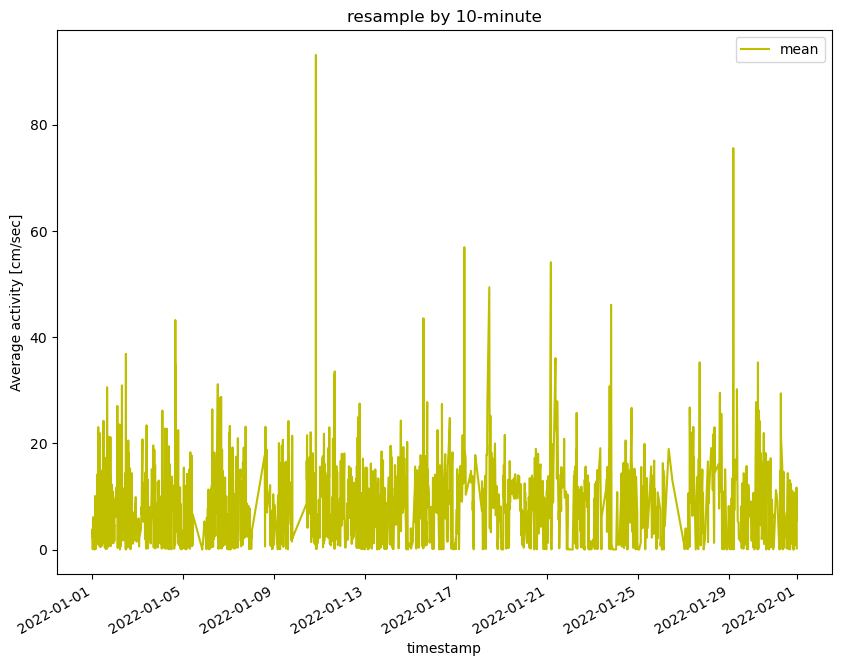

In [88]:
#10분 단위의 평균 활동량 분포
result1.plot(y="mean", color="y", title="resample by 10-minute", ylabel="Average activity [cm/sec]", xlabel="timestamp")

#1시간 단위 그룹화

In [ ]:
onehr = act.resample('1H')
result2 = onehr['calc_act'].agg(['mean', 'min', 'max'])
print(result2) #(774, 3)

#결측제거
result2 = result2.dropna()
print(result2) #609, 3

                         mean       min        max
timestamp                                         
2022-01-01 00:00:00  3.025915  0.011198  14.338601
2022-01-01 01:00:00  3.948859  0.013024   7.813303
2022-01-01 02:00:00  1.965045  0.006504   9.646105
2022-01-01 03:00:00  9.173303  0.065512  67.447458
2022-01-01 04:00:00  6.503876  0.000000  28.781980
...                       ...       ...        ...
2022-01-31 19:00:00  3.453507  0.014785  39.131190
2022-01-31 20:00:00  0.052261  0.005667   0.112500
2022-01-31 21:00:00  8.707639  0.076334  43.773557
2022-01-31 22:00:00  5.980594  0.000000  37.328848
2022-01-31 23:00:00  7.525590  0.030831  31.025631

[744 rows x 3 columns]
                         mean       min        max
timestamp                                         
2022-01-01 00:00:00  3.025915  0.011198  14.338601
2022-01-01 01:00:00  3.948859  0.013024   7.813303
2022-01-01 02:00:00  1.965045  0.006504   9.646105
2022-01-01 03:00:00  9.173303  0.065512  67.447458
2022-01

C:\Users\302-26\AppData\Local\Temp\ipykernel_4976\2183746907.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  onehr = act.resample('1H')


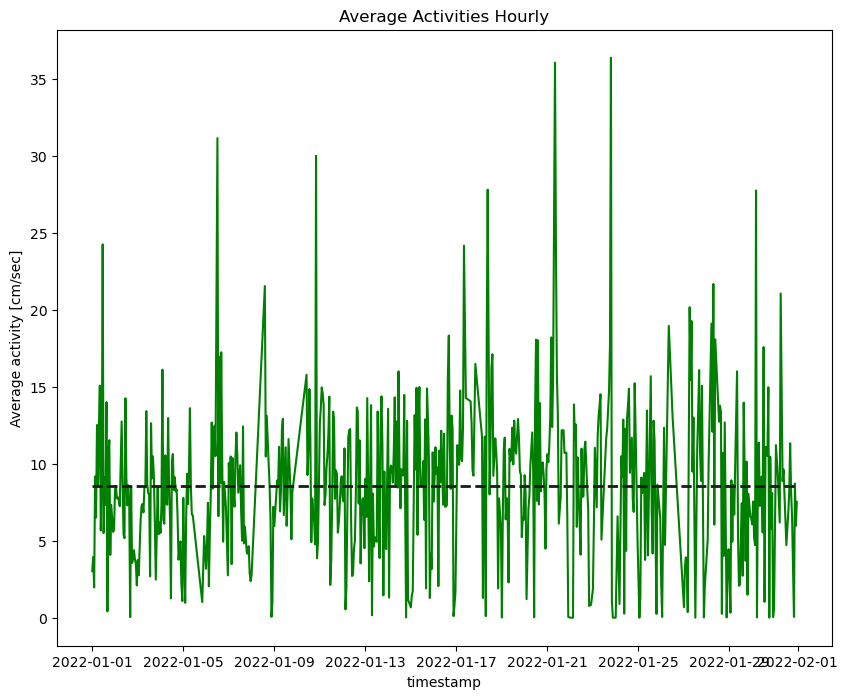

In [70]:
plt.plot(result2['mean'], color='g')

#속도(활동) 평균선
plt.hlines(result2['mean'].mean(),  min(result2.index), max(result2.index),  color='0.1', linestyle='--', linewidth=2)

plt.title("Average Activities Hourly")
plt.xlabel("timestamp")
plt.ylabel("Average activity [cm/sec]")

plt.show()

#1일 단위로 그룹화

In [77]:
oneDay = act.resample('D')
result3 = oneDay['calc_act'].agg(['mean', 'min', 'max'])
print(result3.info()) #(31, 3)
result3 = result3.dropna()
print(len(result3)) #31, 3

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2022-01-01 to 2022-01-31
Freq: D
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mean    31 non-null     float64
 1   min     31 non-null     float64
 2   max     31 non-null     float64
dtypes: float64(3)
memory usage: 992.0 bytes
None
31


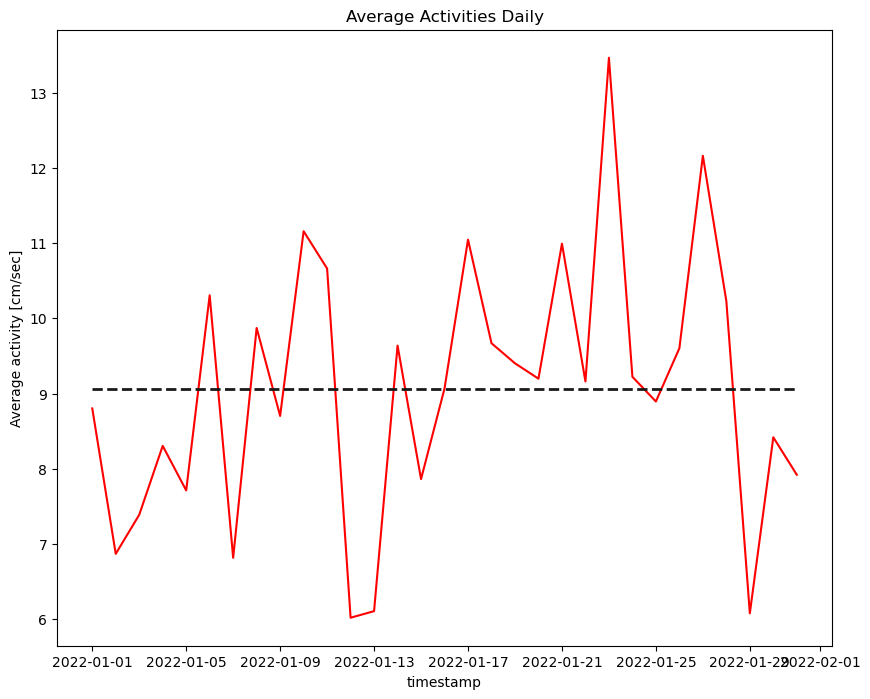

In [78]:
plt.plot(result3['mean'], color='r')

# 속도(활동) 평균선
plt.hlines(result3['mean'].mean(),  min(result3.index), max(result3.index),  color='0.1', linestyle='--', linewidth=2)

plt.title("Average Activities Daily")
plt.xlabel("timestamp")
plt.ylabel("Average activity [cm/sec]")

plt.show()